Color Moments

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import euclidean_distances

Setup

In [4]:
data = np.load("color_moments.npz", allow_pickle=True)
feature_matrix = data["features"]
filenames = data["filenames"]
labels = data["labels"]

Crop automatico per isolare il cervello - Task1-2

In [5]:
def crop_to_brain(img):
    """Ritaglia l'area informativa (cervello) da un'immagine."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        return img[y:y+h, x:x+w]
    return img  # fallback

Estrazione Color Moments su griglia - Task 1-2

In [6]:
def extract_color_moments(img_path):
    """Estrae Color Moments su una griglia 10x10 da un'immagine."""
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata: {img_path}")
        return None

    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = crop_to_brain(img)
    img = cv2.resize(img, (300, 100))  # Griglia uniforme

    h, w, _ = img.shape
    grid_h, grid_w = h // 10, w // 10
    features = []

    for i in range(10):
        for j in range(10):
            cell = img[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            for channel in range(3):
                pixels = cell[:, :, channel].flatten()
                if np.std(pixels) > 0:
                    mean = np.mean(pixels)
                    std = np.std(pixels)
                    sk = skew(pixels)
                    if np.isnan(sk): sk = 0
                else:
                    mean, std, sk = 0, 0, 0
                features.extend([mean, std, sk])
    return features

 Estrazione feature da più cartelle e salvataggio in .npz

In [7]:
def process_and_save_features(base_folder, subfolders, output_file):
    """Estrae le feature da immagini organizzate in sottocartelle e le salva in un file .npz."""
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_color_moments(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    print(f"[SALVATO] Features salvate in {output_file}")

Ricerca immagini simili (Euclidea) - Task 3

In [8]:
def find_k_similar(base_folder,img_path, k):
    """Trova le k immagini più simili in base alla distanza euclidea."""
    query_feature = extract_color_moments(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    distances = euclidean_distances(feature_matrix, query_feature).flatten()
    top_k_idx = np.argsort(distances)[:k]

    print(f"\nTop {k} immagini simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {distances[idx]:.2f}")

    # Visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match = cv2.imread(os.path.join(base_folder, labels[idx], filenames[idx]))
        axs[i+1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={distances[idx]:.2f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

Ricerca immagini simili (Mahalanobis) - Task 3

In [9]:
def find_k_similar_mahalanobis(base_folder, img_path, k):
    """Trova le k immagini più simili usando distanza di Mahalanobis, escludendo la query."""
    # Estrai le feature dalla query
    query_feature = extract_color_moments(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature)

    # Calcola matrice di covarianza delle feature
    cov = np.cov(feature_matrix.T)

    # Inversione con fallback alla pseudoinversa
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("[ERRORE] Uso pseudoinversa per matrice non invertibile.")
        cov_inv = np.linalg.pinv(cov)

    # Calcola distanza di Mahalanobis tra la query e tutte le immagini
    distances = np.array([
        mahalanobis(query_feature, f, cov_inv) for f in feature_matrix
    ])

    # Opzionale: escludi la query stessa (distanza 0)
    # === Escludi la query basandoti sul path ===
    query_filename = os.path.basename(img_path)
    query_label = os.path.basename(os.path.dirname(img_path))

    for i in range(len(filenames)):
        if filenames[i] == query_filename and labels[i] == query_label:
            distances[i] = np.inf
            break

    # Seleziona i top-k indici a distanza minima
    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    # Output testuale
    print(f"\nTop {k} immagini simili (Mahalanobis): {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {top_k_scores[rank]:.2f}")

    # Visualizza le immagini
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match_path = os.path.join(base_folder, labels[idx], filenames[idx])
        img_match = cv2.imread(img_match_path)
        axs[i + 1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i + 1}\nD={top_k_scores[i]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

Esecuzione: Estrazione e salvataggio

In [10]:
# Parametri
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
output_file = "color_moments.npz"

# Estrazione e salvataggio
process_and_save_features(base_folder, subfolders, output_file)

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in color_moments.npz


Esecuzione


Top 5 immagini simili a: Part1/brain_glioma/brain_glioma_0005.jpg
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 49.20
3. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 50.50
4. brain_glioma_0767.jpg | Classe: brain_glioma | Distanza: 286.61
5. brain_glioma_0069.jpg | Classe: brain_glioma | Distanza: 355.25


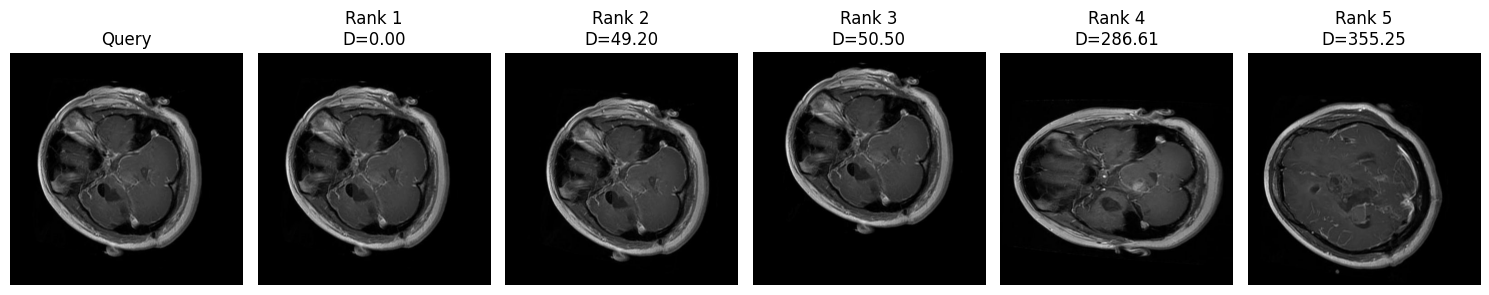

[ERRORE] Uso pseudoinversa per matrice non invertibile.

Top 7 immagini simili (Mahalanobis): Part1/brain_glioma/brain_glioma_0005.jpg
1. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 8.52
2. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 9.34
3. brain_glioma_0767.jpg | Classe: brain_glioma | Distanza: 17.61
4. brain_tumor_0369.jpg | Classe: brain_tumor | Distanza: 19.65
5. brain_glioma_0491.jpg | Classe: brain_glioma | Distanza: 20.40
6. brain_glioma_0169.jpg | Classe: brain_glioma | Distanza: 20.50
7. brain_tumor_0454.jpg | Classe: brain_tumor | Distanza: 20.53


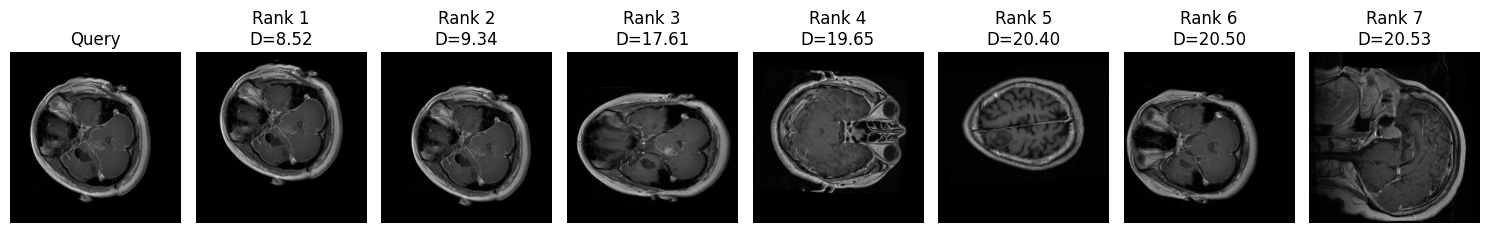

In [11]:
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(base_folder,query_img, k=5)
find_k_similar_mahalanobis(base_folder,query_img, k=7)